# **Chapter 12. k-Nearest Neighbors**

* Imagine that you're trying to predict how I'm going to vote in the next presidential election. If you know nothing else about me (and if you have the data), one sensible approach is to look at how my **neighbors** are planning to vote. Living in Seattle, as I do, my neighbors are invariably planning to vote for the Democratic candidate, which suggests that "Democratic candidate" is a good guess for me as well.

* Now imagine you know more about me than just geography—perhaps you know my
age, my income, how many kids I have, and so on. To the extent my behavior is influenced (or characterized) by those things, looking just at my neighbors who are close to me among all those dimensions seems likely to be an even better predictor than looking at all my neighbors. This is the idea behind **nearest neighbors classification**.

## The Models

* The only things it require are:
>* Some notion of distance 
>* An assumption that points that are close to one another are similar

* In the general situation, we have some data points and we have a corresponding set of labels. 
>* The labels could be True and False, indicating whether each input satisfies
some condition like "is spam?" or "is poisonous?" or "would be enjoyable to watch?"
>* Or they could be categories, like movie ratings (G, PG, PG-13, R, NC-17). Or they could be the names of presidential candidates. 
>* Or they could be favorite programming languages.

## k-Nearest Neighbors (kNN)

![picture](https://drive.google.com/uc?id=1ca5kOOdxxgHanFt_4Eoyiw6sntj7qFOA)

* Let's say we've picked a number _k_ like 3 or 5. Then, when we want to classify some new data point, we find the _k_ nearest labeled points and let them vote on the new output.

In [ ]:
from typing import List
from collections import Counter

def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

assert raw_majority_vote(['a', 'b', 'c', 'b']) == 'b'

* If there is a tie, we have several options:
>* Pick one of the winners at random.
>* Weight the votes by distance and pick the weighted winner.
>* Reduce _k_ until we find a unique winner.

* The implementation of the third option is as follows:

In [ ]:
def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest."""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])

    if num_winners == 1:
        return winner                     # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest

# Tie, so look at first 4, then 'b'
assert majority_vote(['a', 'b', 'c', 'b', 'a']) == 'b'

* With this function it's easy to create a classifier:

In [ ]:
import requests
url = 'https://raw.githubusercontent.com/joelgrus/data-science-from-scratch/master/scratch/linear_algebra.py'
r = requests.get(url)

with open('linear_algebra.py', 'w') as f:
    f.write(r.text)

from typing import NamedTuple
from linear_algebra import Vector, distance

class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def knn_classify(k: int,
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:

    # Order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points,
                         key=lambda lp: distance(lp.point, new_point))

    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    # and let them vote.
    return majority_vote(k_nearest_labels)

## Example: The Iris Dataset

![picture](https://archive.ics.uci.edu/ml/assets/MLimages/Large53.jpg)

* The **Iris** dataset is a staple of machine learning. It contains a bunch of measurements for 150 flowers representing _three species_ of iris. For each flower we have its _petal length_, _petal width_, _sepal length_, and _sepal width_, as well as its species. You can download it from https://archive.ics.uci.edu/ml/datasets/iris:

In [ ]:
import requests
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
r = requests.get(url)

with open('iris.data', 'w') as f:
    f.write(r.text)

def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    sepal_length, sepal_width, petal_length, petal_width, class
    """
    measurements = [float(value) for value in row[:-1]]
    # class is e.g. "Iris-virginica"; we just want "virginica"
    label = row[-1].split("-")[-1]
 
    return LabeledPoint(measurements, label)

with open('iris.data') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader if len(row) > 1]

* We'd like to plot the measurements so we can see how they vary by species. Unfortunately, they are four-dimensional, which makes them tricky to plot. One thing we can do is look at the scatterplots for each of the six pairs of measurements

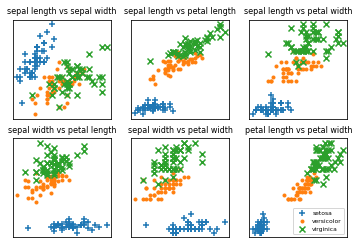

In [ ]:
from typing import Dict
import csv
from collections import defaultdict
    
# We'll also group just the points by species/label so we can plot them.
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)
    
from matplotlib import pyplot as plt
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']  # we have 3 classes, so 3 markers
    
fig, ax = plt.subplots(2, 3)
    
for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
    
        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)
    
ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()

* If you look at those plots, it seems like the measurements really do cluster by species. For example, looking at sepal length and sepal width alone, you probably couldn't distinguish between _versicolor_ and _virginica_. But once you add petal length and width into the mix, it seems like you should be able to predict the species based on the nearest neighbors.

* To start with, let's split the data into a test set and a training set:

In [ ]:
import random

def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]

import requests
url = 'https://raw.githubusercontent.com/joelgrus/data-science-from-scratch/master/scratch/machine_learning.py'
r = requests.get(url)

with open('machine_learning.py', 'w') as f:
    f.write(r.text)

from machine_learning import split_data

random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)
assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

* The training set will be the "neighbors" that we'll use to classify the points in the test set. 
* We just need to choose a value for _k_, the number of neighbors who get to vote.
>* Too small (think _k_ = 1), and we let outliers have too much influence.
>* Too large (think _k_ = 105), and we just predict the most common class in the dataset. 
* Here we'll just use _k_ = 5:

In [ ]:
from typing import Tuple
   
# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0
   
for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label
    
    if predicted == actual:
        num_correct += 1
    
    confusion_matrix[(predicted, actual)] += 1
    
pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


## The Dimensionality Curse

* The k-nearest neighbors algorithm runs into trouble in higher dimensions thanks to the "**curse of dimensionality**," which boils down to the fact that high-dimensional spaces are **vast**. Points in high-dimensional spaces tend not to be close to one another at all.

* One way to see this is by randomly generating pairs of points in the _d_-dimensional unit cube in a variety of dimensions, and calculating the distances between them.

In [ ]:
import tqdm
dimensions = range(1, 101)
    
avg_distances = []
min_distances = []
    
random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 10000)      # 10,000 random pairs
    avg_distances.append(sum(distances) / 10000)  # track the average
    min_distances.append(min(distances))          # track the minimum
    
min_avg_ratio = [min_dist / avg_dist
                 for min_dist, avg_dist in zip(min_distances, avg_distances)]

Curse of Dimensionality: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


* As the number of dimensions increases, the average distance between points increases.

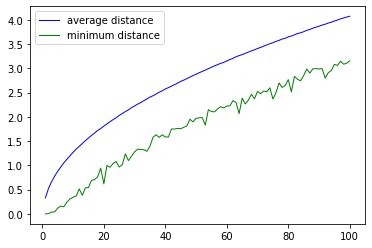

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({'x_values': dimensions, 'y1_values': avg_distances, 'y2_values': min_distances})

plt.plot('x_values', 'y1_values', data=df, marker='', color='blue', linewidth=1, label='average distance')
plt.plot('x_values', 'y2_values', data=df, marker='', color='green', linewidth=1, label='minimum distance')

plt.legend()
plt.show()

* What's more problematic is the ratio between the closest distance and the
average distance.

* In low-dimensional datasets, the closest points tend to be much closer than average. But two points are close only if they're close in every dimension, and every extra dimension is another opportunity for each point to be farther away from every other point. When you have a lot of dimensions, it's likely that the
closest points are _not_ much closer than average, so two points being close does _not_ mean very much

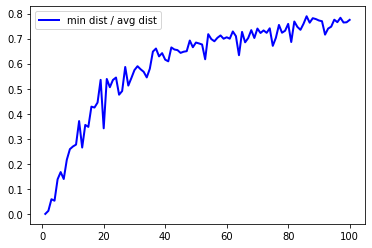

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({'x_values': dimensions, 'y_values': min_avg_ratio})

plt.plot( 'x_values', 'y_values', data=df, marker='', color='blue', linewidth=1, label='min dist / avg dist')

plt.legend()
plt.show()

* A different way of thinking about the problem involves the sparsity of higherdimensional spaces. 
>* If you pick 50 random numbers between 0 and 1, you'll probably get a pretty good sample of the unit interval.
>* If you pick 50 random points in the unit _square_, you’ll get less coverage
>* And in three dimensions, less still.

![picture](https://drive.google.com/uc?id=1dAe1Yzyrswyvsm_LkeUuW3FimY_J0_uc)


* You can see already that there are starting to be large empty spaces with no points near them.
* In more dimensions, those large empty spaces represent regions far from all the points you want to use in your predictions.
* So if you're trying to use nearest neighbors in higher dimensions, it's probably a good idea to do some kind of **dimensionality reduction** first.